![logo](./figures/LogoLine_horizon_C3S.png)

# Time series

This Jupyter Notebook reproduces the Time Series (see figure bellow) product from the C3S Atlas.

![time_serie](./figures/t-CMIP6_timeseries.png)

The time series panel displays the annual/seasonal values year by year, along the historical or historical and future climate periods. For **observations/reanalysis**, the time-series panel displays the regionally aggregated annual/seasonal series. For climate **projections**, the time-series displays the regionally aggregated annual/seasonal series for the raw values or the changes (anomalies relative to the selected baseline in this case) for all the model simulations forming the ensemble, as well as the ensemble median. A gray shading indicates the particular period selected, as represented in the map; in the case of Global Warming Levels, the shading area exhibits different gray shading intensities according to the overlaps of 20-year periods where the warming level is first reached by the different models (higher shade intensity indicates years with higher overlap). Detailed (percentile) information is also provided.

### Load Python packages and clone and install the c3s-atlas GitHub repository from the ecmwf-projects

Clone (`git clone`) the [c3s-atlas](https://github.com/ecmwf-projects/c3s-atlas) repository and install them (`pip install -e .`).

Further details on how to clone and install the repository are available in the [requirements section](https://github.com/ecmwf-projects/c3s-atlas?tab=readme-ov-file#requirements)

In [4]:
import os
import xarray as xr
import glob
from datetime import date
import numpy as np
from pathlib import Path
import cdsapi
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from c3s_atlas.utils import (
    season_get_name,
    extract_zip_and_delete,
)
from c3s_atlas.customized_regions import (
    Mask
)
from c3s_atlas.analysis import (
    annual_weighted_average
)
from c3s_atlas.products import (
    time_series,
)
from c3s_atlas.GWLs import (
    load_GWLs,
    select_member_GWLs,
    get_selected_data
)

## Time series for observations/reanalysis
Linear trend analysis is included in the time series for observations and reanalysis. However, this analysis is not recommended for projections, as climate change may not scale linearly.

### Download climate data with the CDS API
- Catalogue: [Gridded dataset underpinning the Copernicus Interactive Climate Atlas](https://cds.climate.copernicus.eu/datasets/multi-origin-c3s-atlas?tab=overview)

- [How to use the CDS API](https://cds.climate.copernicus.eu/how-to-api)

In [8]:
project = "ERA5"
var = 'pr'
season = [3, 4, 5] # Months

In [9]:
dest = Path('./data/ERA5')
os.makedirs(dest, exist_ok=True)

In [ ]:
filename = 'pr_ERA5_mon_194001-202212.zip'

dataset = "multi-origin-c3s-atlas"
request = {
    'origin': 'era5',
    'domain': 'global',
    'period': '1940-2022',
    'variable': 'monthly_mean_of_daily_accumulated_precipitation',
    'area': [44.5, -9.5, 35.5, 3.5]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download(dest / filename)
extract_zip_and_delete(dest / filename) 

In [11]:
ds = xr.open_dataset(dest / "pr_ERA5_mon_194001-202212.nc")

In [13]:
attrs = {
    "project" : project,
    "variable": var,
    "season": season,
    "season_name" : season_get_name(season),
    "actual_year": date.today().year,
    "unit" : ds[var].units    
}

### Analysis

In [14]:
trend_period=slice('1991','2020')

In [15]:
mask = Mask(ds).regions_AR6(['MED'])
filtered_ds = ds.where(mask)

In [16]:
time_series_ds, results = annual_weighted_average(filtered_ds, var, 
                                                  season, trend = True, 
                                                  trend_period=trend_period)

### Plot

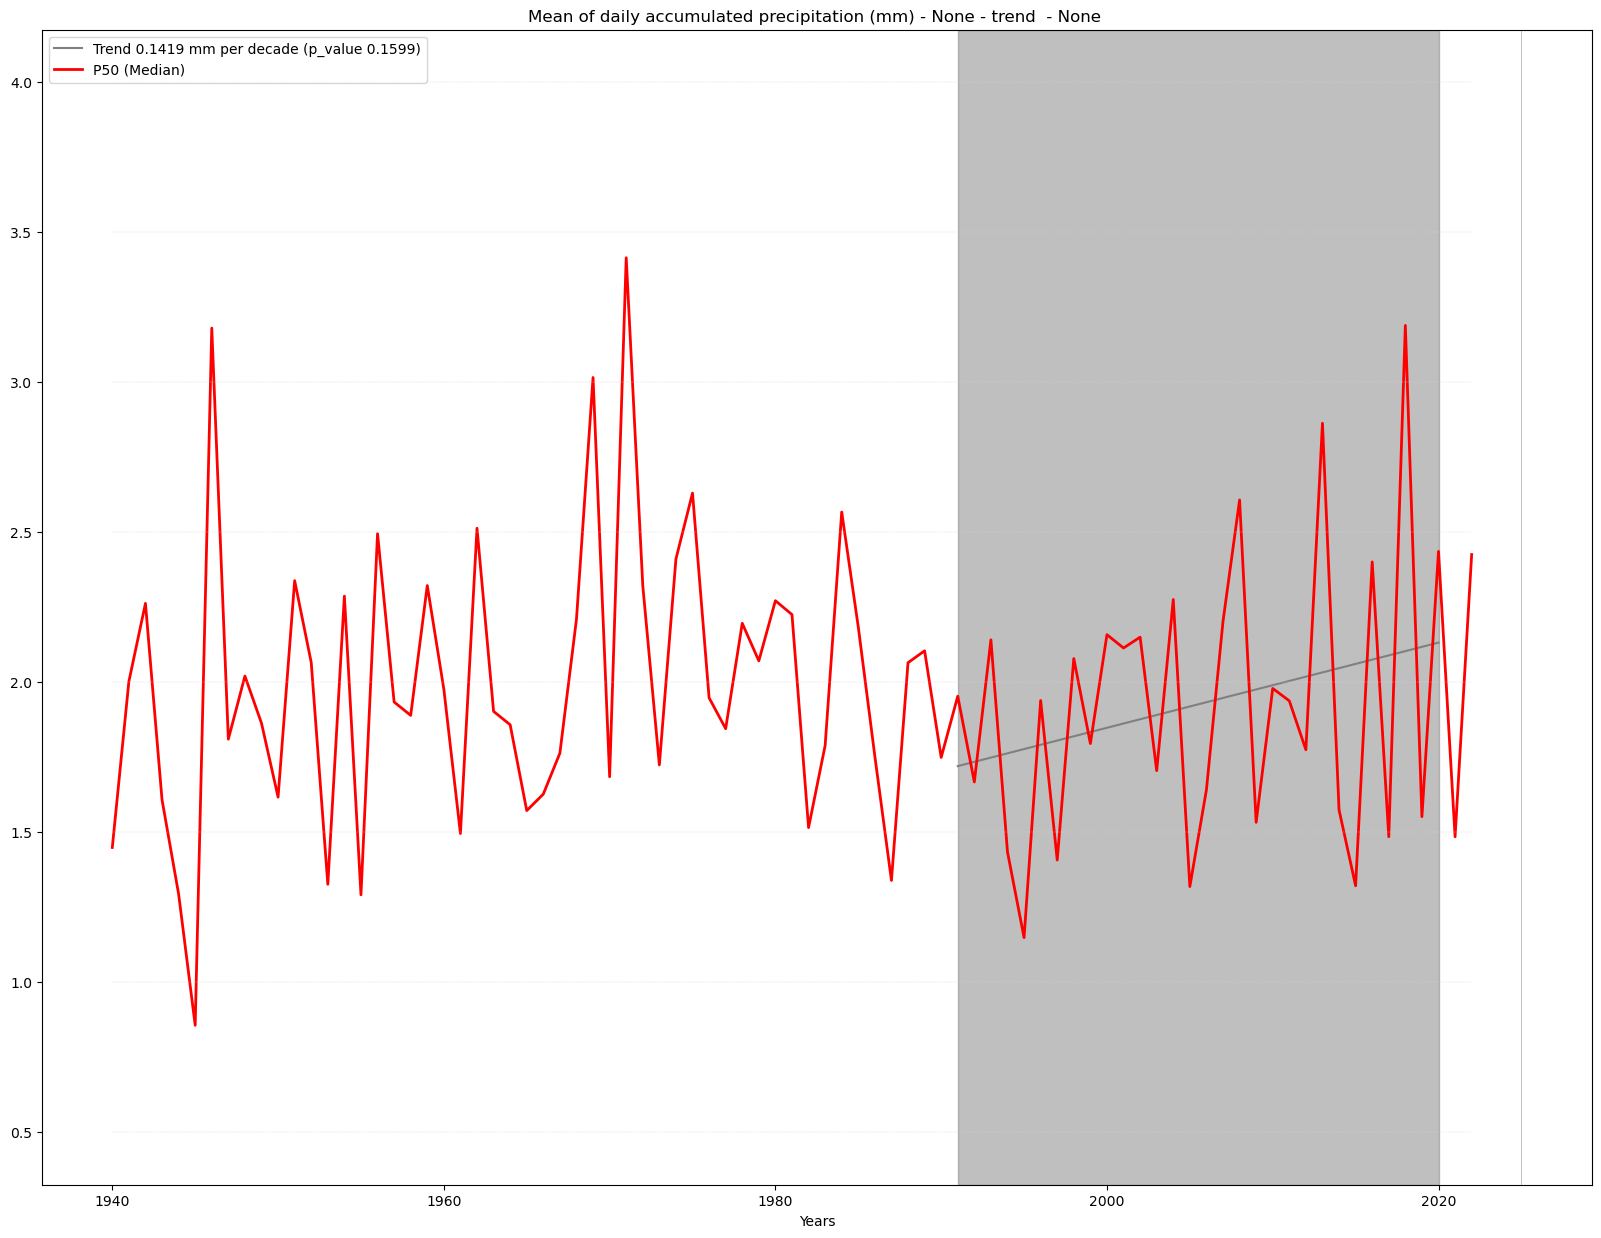

In [17]:
time_series_plot = time_series(time_series_ds, var, attrs, 
                               mode = 'trend', season = season, 
                               results = results, trend_period=trend_period)

Linear trend analysis is ony calculated for the chosen trend period

### Download climate data with the CDS API
- Catalogue: [Gridded dataset underpinning the Copernicus Interactive Climate Atlas](https://cds.climate.copernicus.eu/datasets/multi-origin-c3s-atlas?tab=overview)

- [How to use the CDS API](https://cds.climate.copernicus.eu/how-to-api)

In [34]:
project = "E-OBS"
var = 'pr'
season = [3, 4, 5] # Months

In [35]:
dest = Path('./data/E-OBS')
os.makedirs(dest, exist_ok=True)

In [ ]:
filename = 'pr_eobs_mon_194001-202212.zip'

dataset = "multi-origin-c3s-atlas"
request = {
    'origin': 'e_obs',
    'domain': 'europe',
    'period': '1950-2021',
    'variable': 'monthly_mean_of_daily_accumulated_precipitation',
    'area': [44.5, -9.5, 35.5, 3.5]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download(dest / filename)
extract_zip_and_delete(dest / filename) 

In [37]:
ds = xr.open_dataset(dest / "pr_eobs_mon_194001-202212.nc")

In [38]:
attrs = {
    "project" : project,
    "variable": var,
    "season": season,
    "season_name" : season_get_name(season),
    "actual_year": date.today().year,
    "unit" : ds[var].units    
}

### Analysis
The **time_series** function calculates and returns p-values for linear regression trends for the **trend_period** selected. Robustness is defined using the significance of the linear trends as obtained from standard hypothesis testing (and obscuring regions with non-significant trends using "x"). 

A p-value indicates the level of significance of the trend:
- A small p-value (usually less than 0.05) means it’s very unlikely to be random — so we can trust the trend is significant.
- A large p-value means the trend might just be noise or coincidence, so we don’t consider it reliable.

In [39]:
trend_period=slice('1991','2020')

In [40]:
mask = Mask(ds).regions_AR6(['MED'])
filtered_ds = ds.where(mask)

In [41]:
time_series_ds, results = annual_weighted_average(filtered_ds, var, 
                                                  season, trend = True, 
                                                  trend_period=trend_period)

### Plot

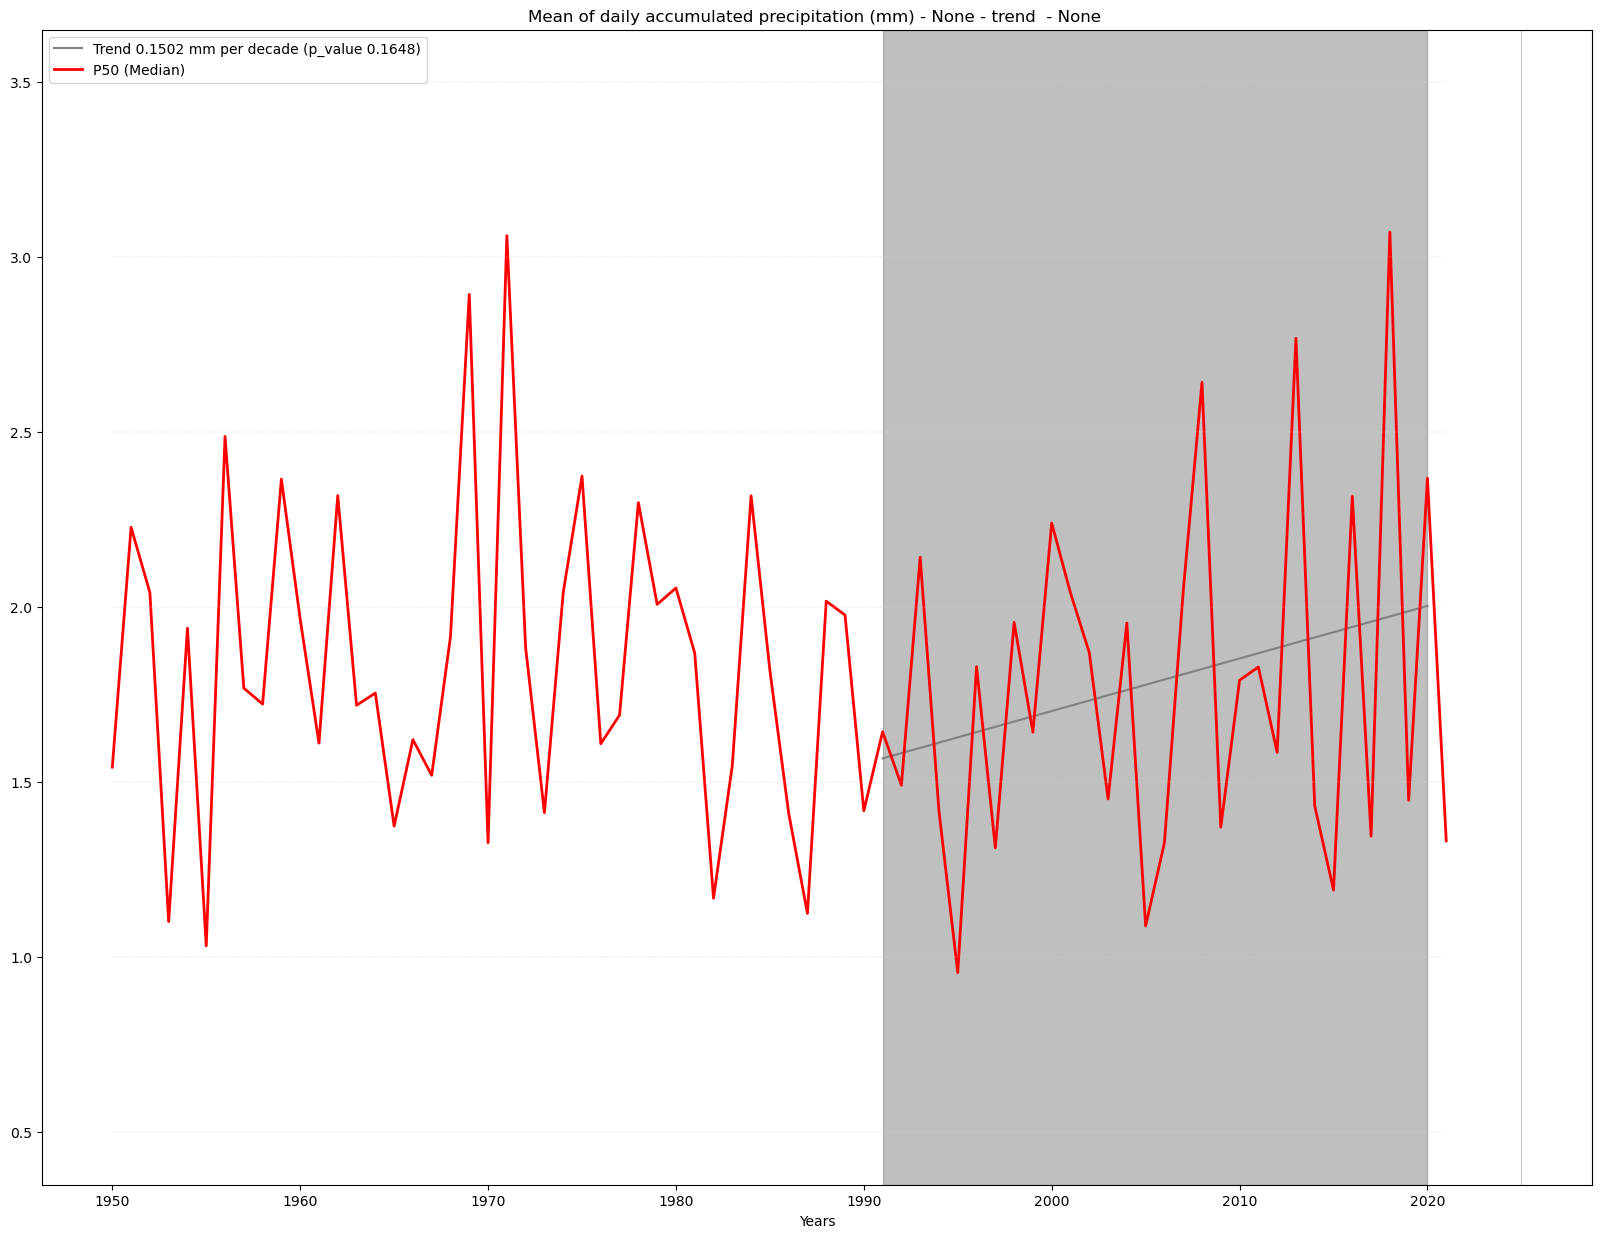

In [42]:
time_series_plot = time_series(time_series_ds, var, attrs, 
                               mode = 'trend', season = season, 
                               results = results, trend_period=trend_period)

Linear trend analysis is ony calculated for the chosen trend period

## Time series for projections
The time series for projections show all the model simulations forming the ensemble, as well as the ensemble median

In [2]:
project = "CMIP6"
scenario = "ssp370"
var = 'pr'
dest = Path('./data/CMIP6') # directory to download the files
os.makedirs(dest, exist_ok=True)

##### Download historical data

In [ ]:
filename = 'pr_CMIP6_historical_mon_185001-201412.zip'
dataset = "multi-origin-c3s-atlas"
request = {
    'origin': 'cmip6',
    'experiment': 'historical',
    'domain': 'global',
    'variable': 'monthly_mean_of_daily_accumulated_precipitation',
    'area': [44.5, -9.5, 35.5, 3.5]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download(dest / filename)
extract_zip_and_delete(dest / filename) 

##### Download SSP scenario

In [ ]:
filename = 'pr_CMIP6_ssp370_mon_201501-210012.zip'
dataset = "multi-origin-c3s-atlas"
request = {
    'origin': 'cmip6',
    'experiment': 'ssp3_7_0',
    'domain': 'global',
    'variable': 'monthly_mean_of_daily_accumulated_precipitation',
    'area': [44.5, -9.5, 35.5, 3.5]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download(dest / filename)
extract_zip_and_delete(dest / filename) 

#### Concatenate historical and SSP scenarios
Note that the historical and SSP scenarios may have a different number of members. Here, common members from the historical and SSP scenarios are concatenated into a single [xarray.Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) to facilitate their use going forward.

In [3]:
ds_hist = xr.open_dataset(dest / "pr_CMIP6_historical_mon_185001-201412.nc")
ds_sce = xr.open_dataset(dest / "pr_CMIP6_ssp370_mon_201501-210012.nc")
mem_inters = np.intersect1d(ds_hist.member_id.values, ds_sce.member_id.values)
ds_hist = ds_hist.isel(member = np.isin(ds_hist.member_id.values, mem_inters))
ds_sce = ds_sce.isel(member = np.isin(ds_sce.member_id.values, mem_inters))
ds = xr.concat([ds_hist, ds_sce], dim = 'time')

##### Define season

In [4]:
season = [3, 4, 5] # Months

In [5]:
attrs = {
    "project" : project,
    "scenario": scenario,
    "variable": var,
    "season": season,
    "season_name" : season_get_name(season),
    "actual_year": date.today().year,
    "unit" : ds[var].units    
}

#### Select Region
To reduce data size and download time, a geographical subset focusing on a specific area within the European region (Spain) is selected.

In [6]:
mask = Mask(ds).European_contries(['ESP'])
filtered_ds = ds.where(mask)

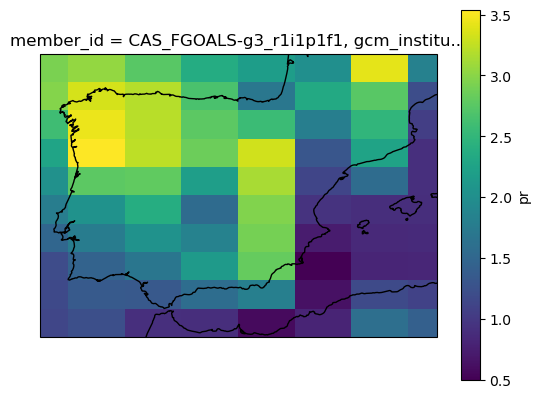

In [7]:
# mean spatial map for one member
ax = plt.axes(projection=ccrs.PlateCarree())  # Use PlateCarree for lat/lon projections
filtered_ds['pr'].isel(member=0).mean(dim='time').plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()

### Analysis for the product
The **annual_weighted_average** function calculates the yearly spatial mean of a dataset, weighted by the cosine of the latitude. This is a common approach to account for the varying size of grid cells at different latitudes, as areas near the poles have smaller grid cells than those near the equator. By applying this weighting, the function ensures that each grid cell contributes appropriately to the overall average, regardless of its geographical location.

In [8]:
time_series_ds = annual_weighted_average(filtered_ds, var, season = season)

### Plot

#### a) Climatology

In [9]:
mode = 'climatology'
period = slice(2081, 2100)

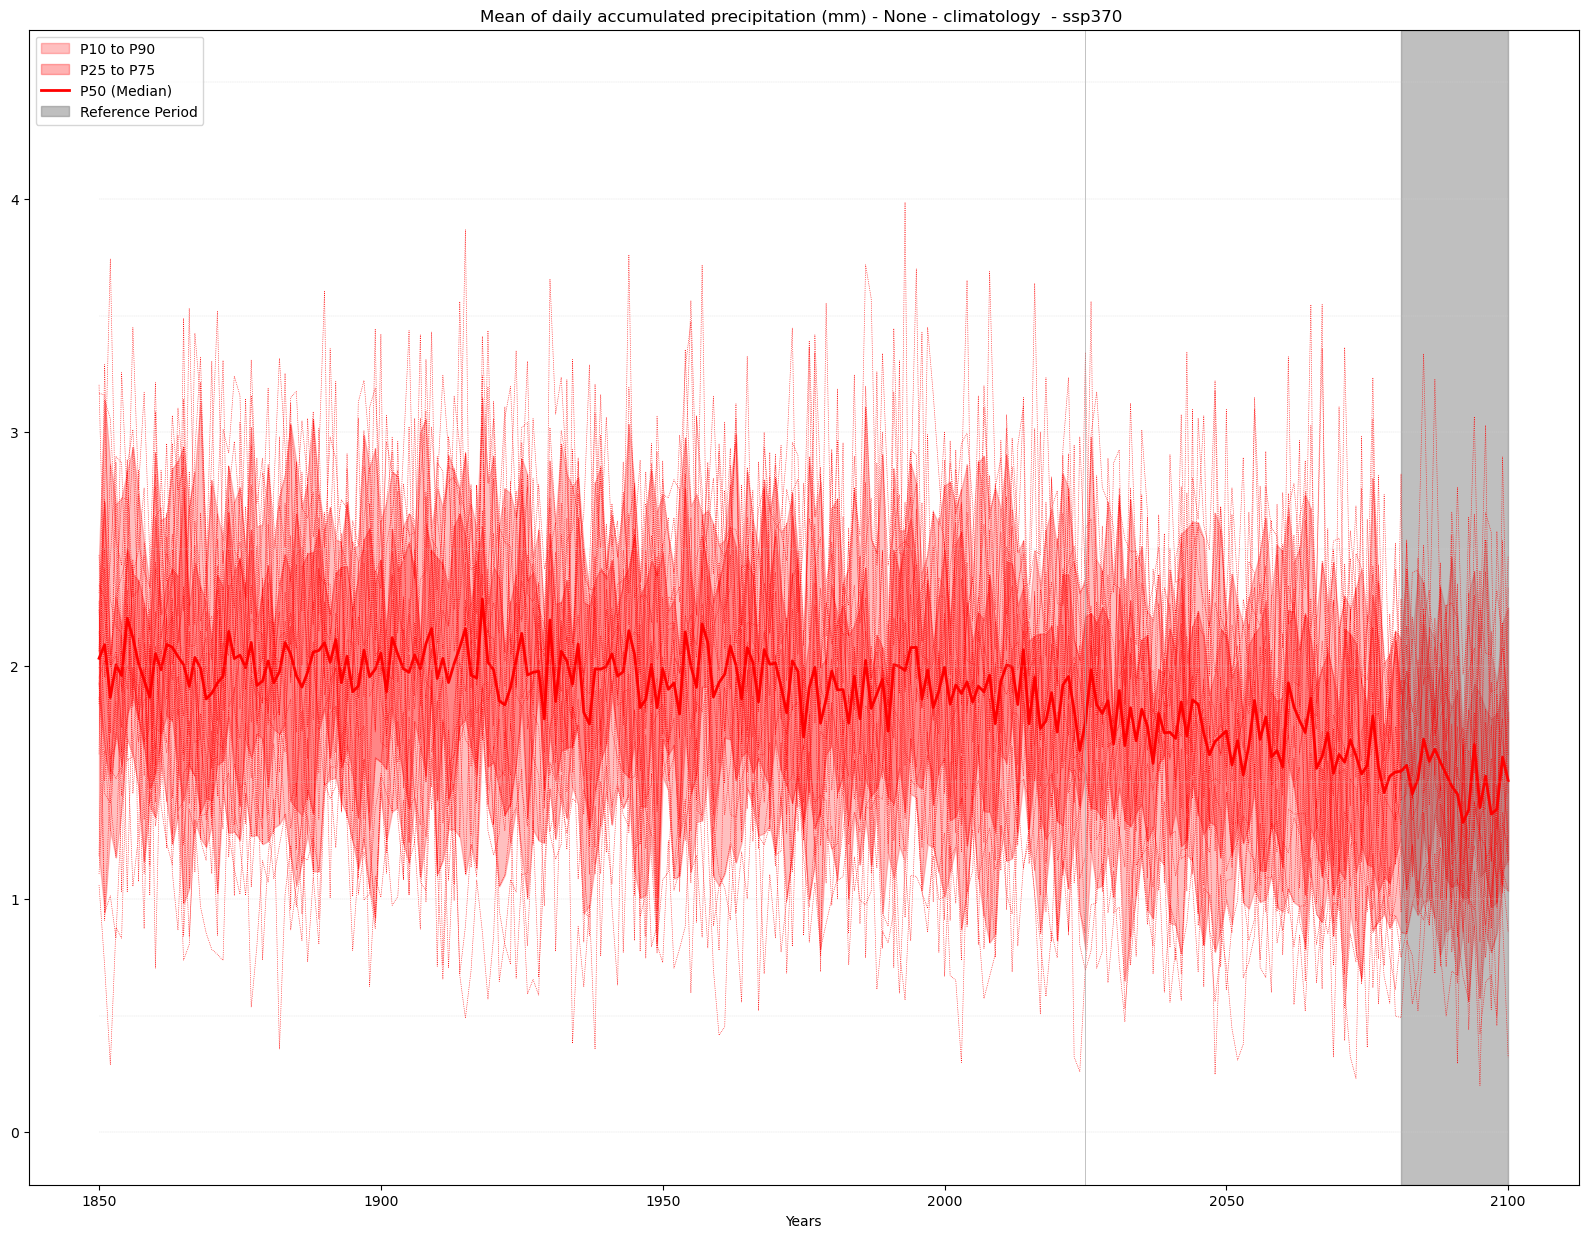

In [10]:
time_series_plot = time_series(time_series_ds, var, attrs, 
                               mode = mode, season = season, period = period)

#### b) Absolute change

In [11]:
mode = 'change'
diff = 'abs'
period = slice(2081,2100)
baseline_period = slice(1981,2010)

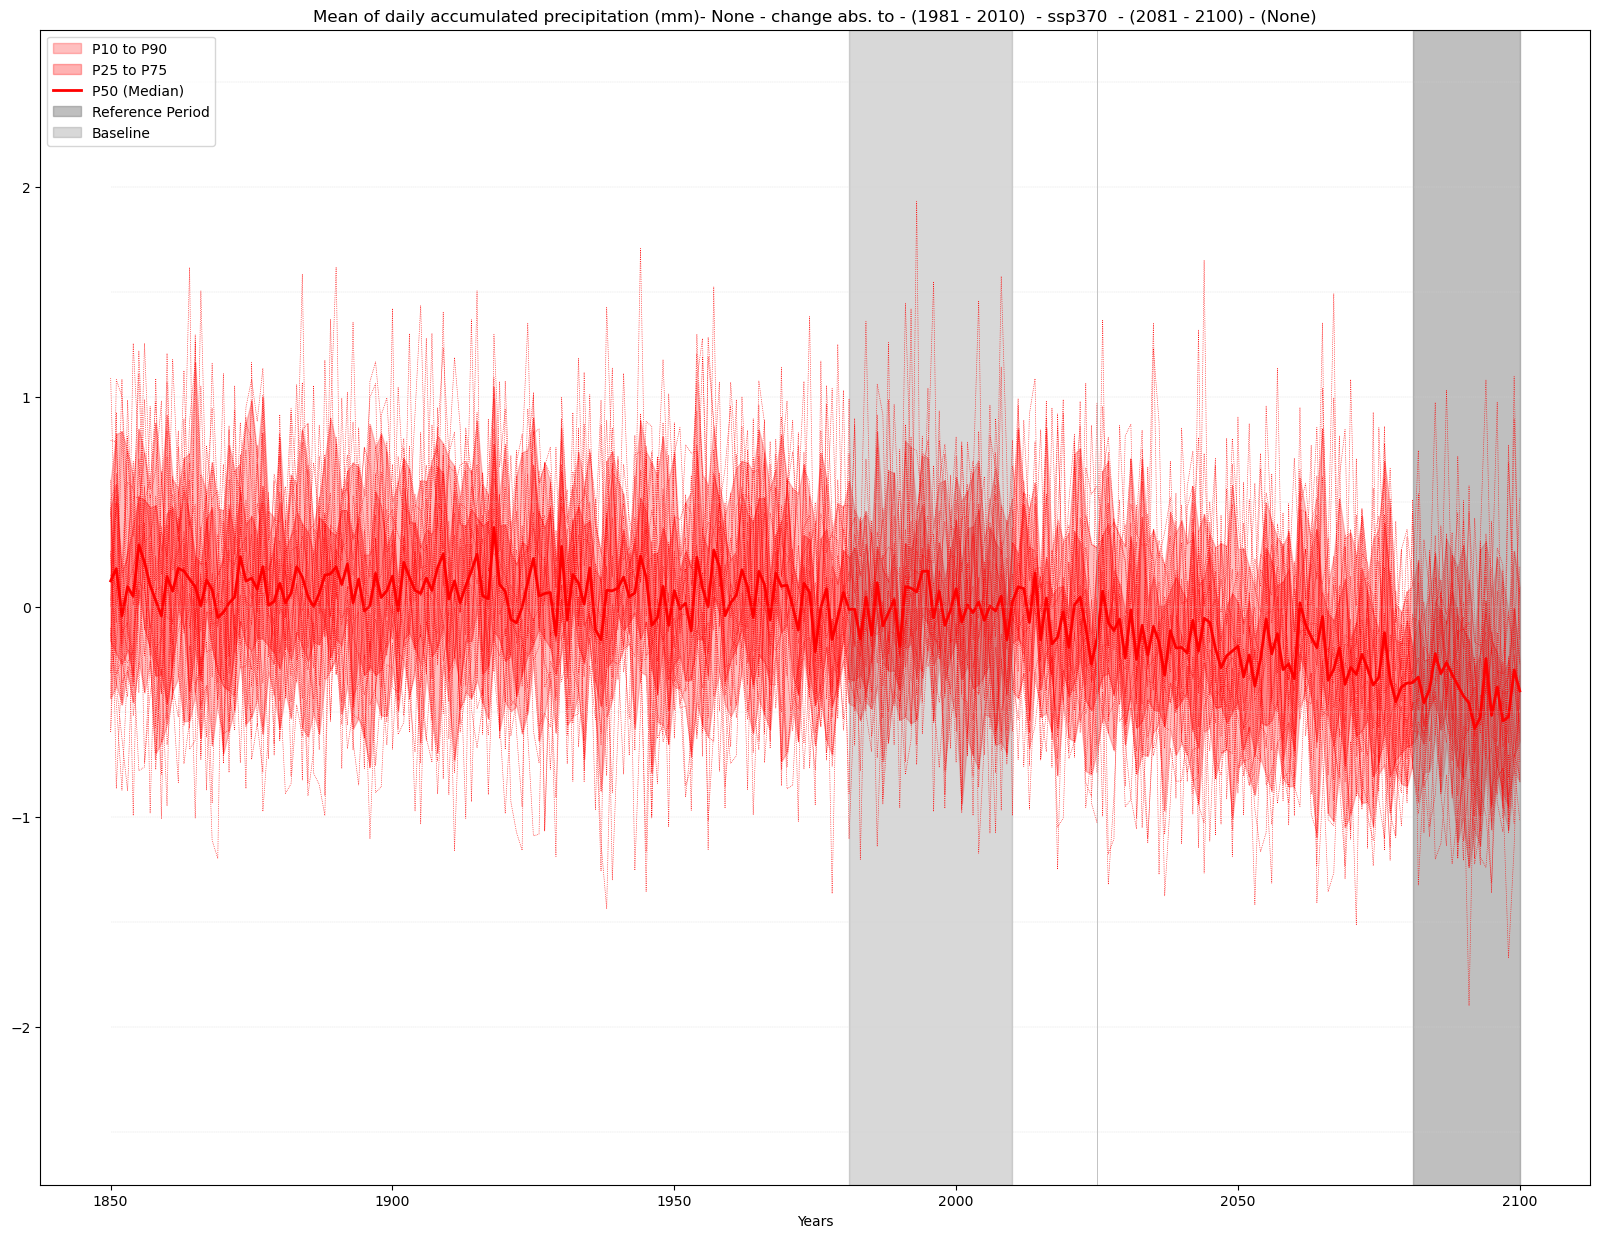

In [12]:
time_series_plot = time_series(time_series_ds, var, attrs, 
                               mode = mode, diff = diff, season = season,
                               baseline_period = baseline_period, period = period)

#### c) Relative change

In [13]:
mode = 'change'
diff = 'rel'
period = slice(2081,2100)
baseline_period = slice(1981,2010)

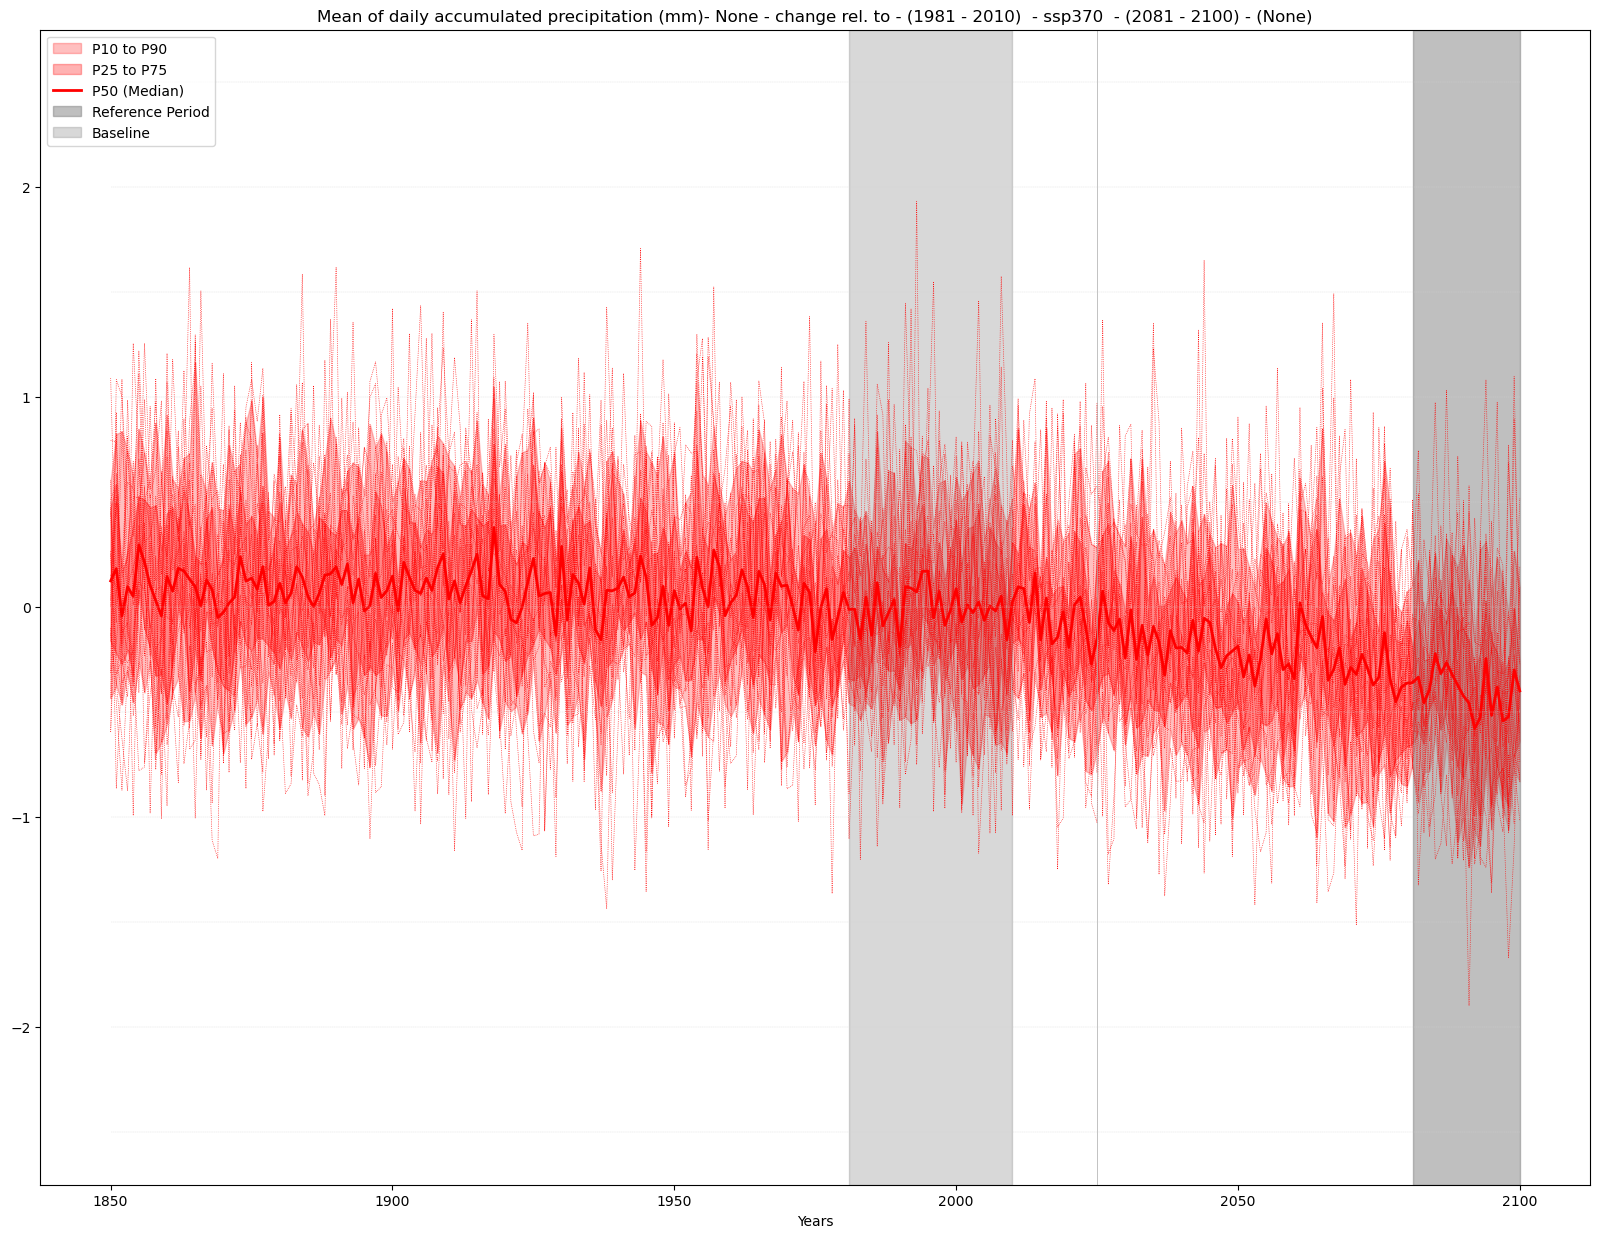

In [14]:
time_series_plot = time_series(time_series_ds, var, attrs, 
                               mode = mode, diff = diff, season = season,
                               baseline_period = baseline_period, period = period)

## Globar Warming Levels
Here, the time series are displayed for a specific Global Warming Level (GWL). To achieve this, the 20-year period in which each ensemble member reaches the chosen GWL is selected. The time series are then shown, representing either climatology or change for this specific period and region (Spain in this notebook).

These periods are calculated in the notebook [GWLs.ipynb](GWLs.ipynb) for CMIP5 and CMIP6. For CORDEX, the results from the driving CMIP5 models are used.

In [15]:
#Load the data and get the intersection of the members
GWL= '4'
GWLs_ds = load_GWLs(project)
GWLs_members_with_period = select_member_GWLs(filtered_ds, GWLs_ds, project, scenario, GWL)

In [16]:
 filtered_GWLs_ds = get_selected_data(filtered_ds, GWLs_members_with_period)

### Analysis

In [17]:
time_series_GWL_ds = annual_weighted_average(filtered_GWLs_ds, var, season)

### Plot

In [18]:
mode = 'climatology'
baseline_period = slice(1981,2010)

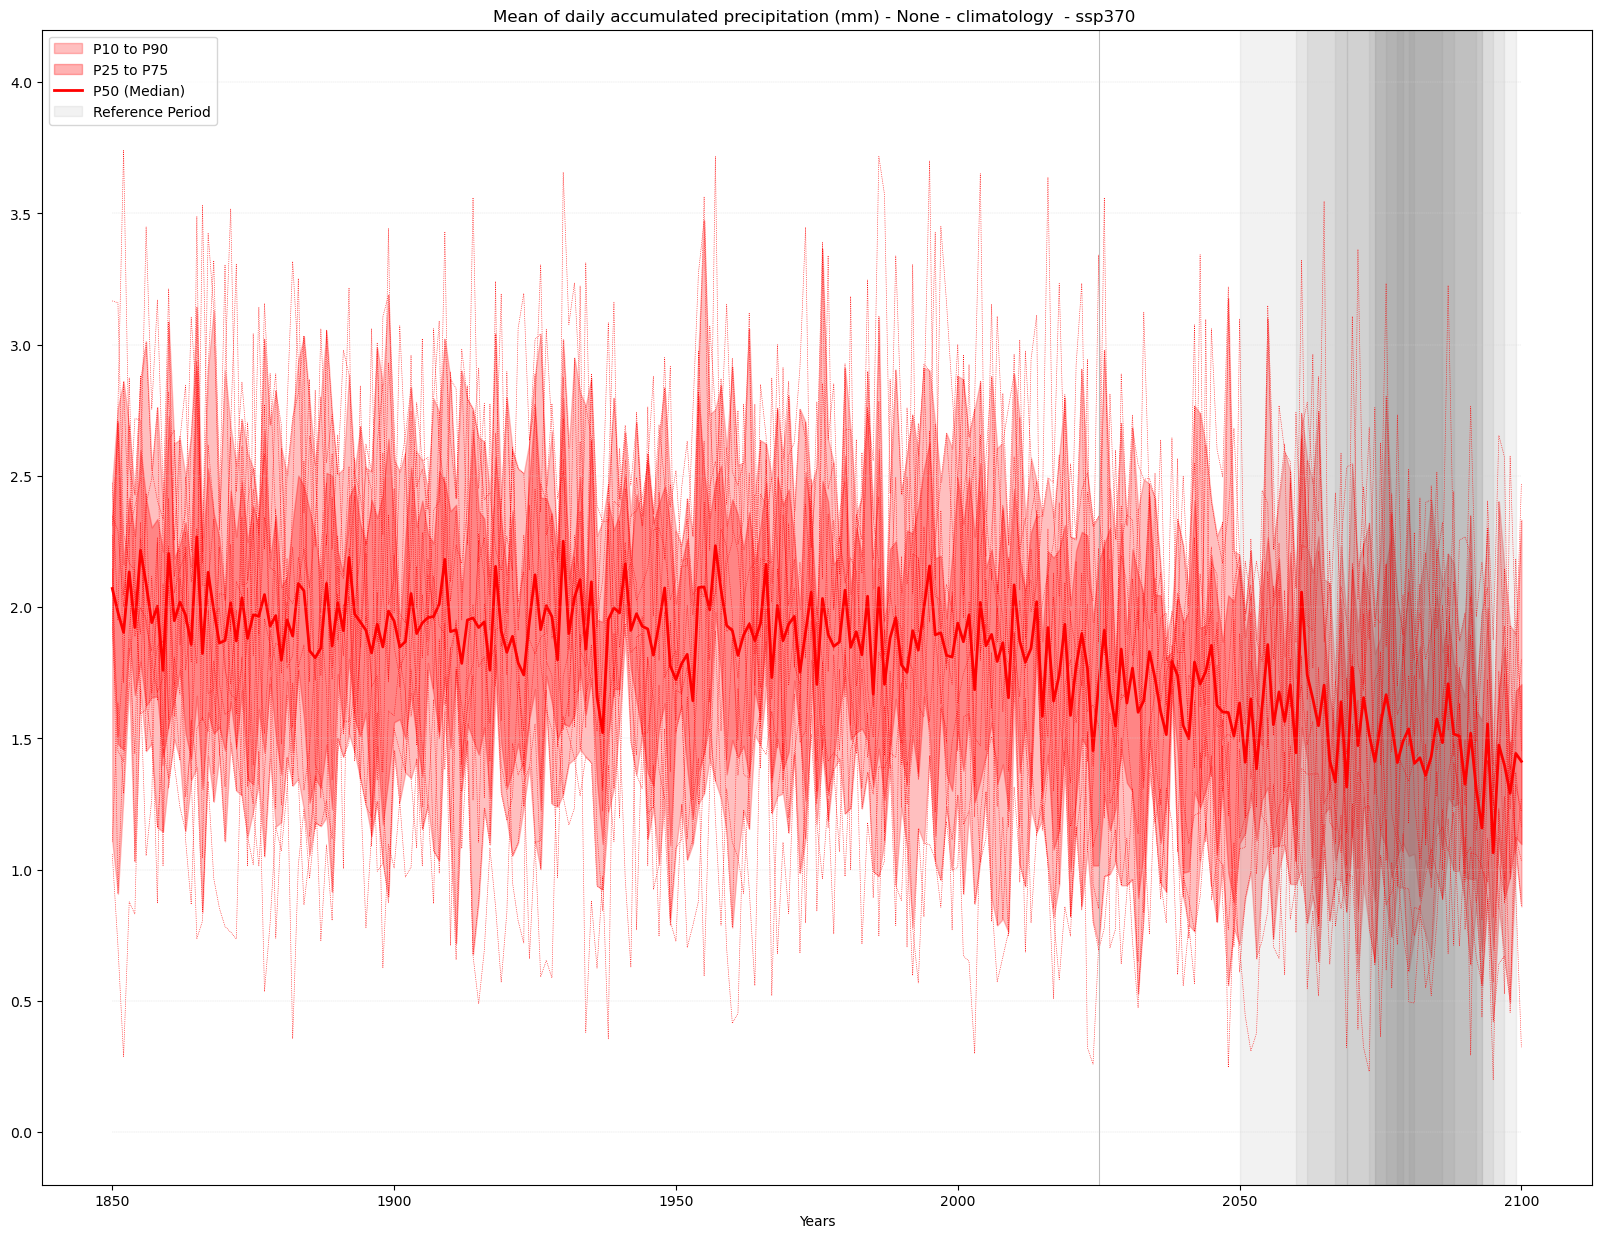

In [19]:
time_series_plot = time_series(time_series_GWL_ds, var, attrs, 
                               mode = mode, season = season, 
                               baseline_period = baseline_period,
                               GWL = GWLs_members_with_period, GWLs = GWL)